Run a basic ARIMA model and make some plots to evaluate fit

In [75]:
import pandas as pd
from covid_project.data_utils import clean_covid_data, clean_policy_data, prep_policy_data, prepare_new_df, prepare_data
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
from tqdm.notebook import tqdm
import warnings
from statsmodels.tsa.arima.model import ARIMA
from covid_project.plotting_funcs import plot_cases, plot_cases_and_policies

In [76]:
import json

case_data = clean_covid_data()
policy_data = clean_policy_data()
with open("./data/dev_arima_results.json", 'r') as f:
    arima_results = json.load(f)

In [11]:
arima_results = pd.DataFrame(arima_results)
arima_results.sort_values(by='aic')

,p,d,q,aic,bic
218,2,2,2,14.000000,45.927215
346,3,5,1,14.000000,45.897448
572,5,9,0,16.000000,52.408643
564,5,8,0,16.000000,52.420063
661,6,8,0,18.000000,58.972571
...,...,...,...,...,...
93,0,9,3,12178.341636,12205.648118
187,1,9,0,12487.140001,12505.344323
91,0,9,1,12586.453069,12604.657390
80,0,8,0,12597.232036,12610.889560


In [15]:
test_df = pd.read_csv("./data/single_policy_bins/" +\
                      os.listdir("./data/single_policy_bins/")[0],
                     index_col=0, header=1)
test_df = test_df[(test_df['state']=='Georgia') & (test_df['county'] == 'fulton')]

In [25]:
test_df.columns

Index(['location_type', 'state', 'county', 'date', 'new_cases_1e6',
       'new_deaths_1e6', 'new_cases_7day_1e6', 'new_deaths_7day_1e6', '0-14',
       '15-999'],
      dtype='object')

In [26]:
model = ARIMA(
    test_df['new_cases_7day_1e6'].values,
    order = (2, 2, 2),
).fit()

In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  709
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1714.483
Date:                Sat, 22 Jun 2024   AIC                           3438.965
Time:                        09:36:50   BIC                           3461.770
Sample:                             0   HQIC                          3447.777
                                - 709                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0527      0.147      0.358      0.721      -0.236       0.342
ar.L2         -0.1413      0.043     -3.309      0.001      -0.225      -0.058
ma.L1         -1.0370      0.145     -7.153      0.000      -1.321      -0.753
ma.L2          0.2740      0.110      2.495      0.013       0.059       0.489
sigma2         7.4653      0.132     56.424      0.000       7.206       7.725
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             50634.53
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              13.04   Skew:                             2.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
pred = model.predict()

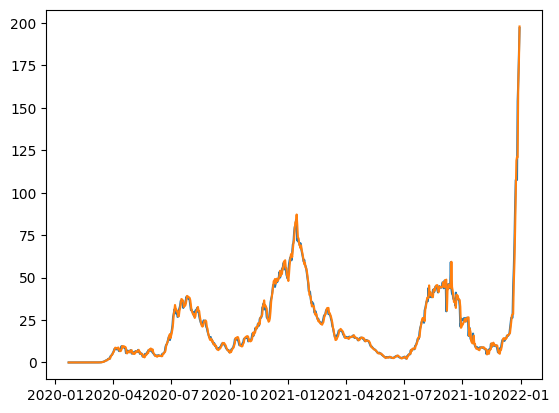

In [30]:
plt.plot(pd.to_datetime(test_df['date']), test_df['new_cases_7day_1e6'])
plt.plot(pd.to_datetime(test_df['date']), pred)

In [31]:
pred = model.forecast()

In [32]:
pred

array([214.36294889])

try fitting for the next 6 months, then forecasting for the next 6

In [37]:
test_df.set_index('date')

,location_type,state,county,new_cases_1e6,new_deaths_1e6,new_cases_7day_1e6,new_deaths_7day_1e6,0-14,15-999
date,,,,,,,,,
2020-01-22,county,Georgia,fulton,0.00,0.00,0.000000,0.000000,0,0
2020-01-23,county,Georgia,fulton,0.00,0.00,0.000000,0.000000,0,0
2020-01-24,county,Georgia,fulton,0.00,0.00,0.000000,0.000000,0,0
2020-01-25,county,Georgia,fulton,0.00,0.00,0.000000,0.000000,0,0
2020-01-26,county,Georgia,fulton,0.00,0.00,0.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...,...
2021-12-26,county,Georgia,fulton,0.00,0.00,107.530859,0.209413,0,1
2021-12-27,county,Georgia,fulton,492.61,0.59,153.942355,0.251492,0,1
2021-12-28,county,Georgia,fulton,169.98,0.49,165.280037,0.251492,0,1


<Figure size 640x480 with 0 Axes>

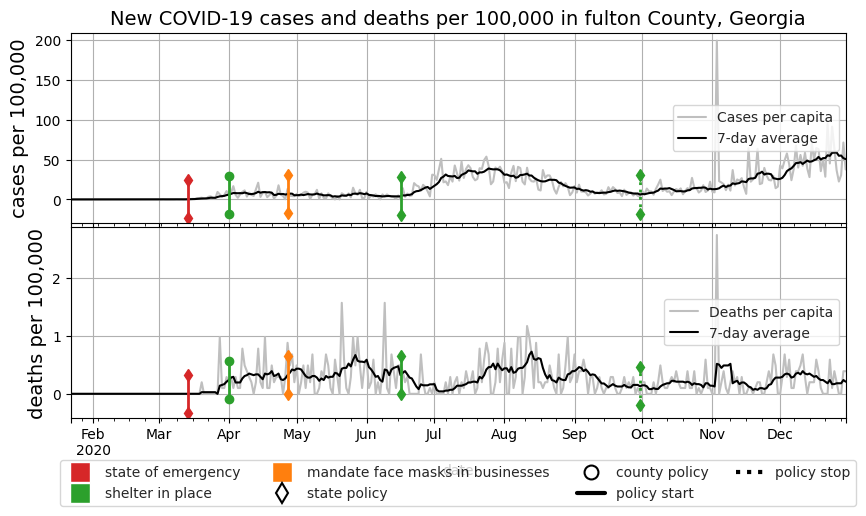

In [77]:
plot_cases_and_policies(
    county='fulton',
    state='Georgia',
    case_data=case_data,
    policy_data=policy_data,
);

In [73]:
test_df['date'] = pd.to_datetime(test_df['date'])
data = test_df.set_index('date')
cutoff = '2020-09-01'
end = '2020-09-14'
train_data = data[data.index < cutoff]
test_data = data[(data.index >= cutoff) & (data.index <= end)]

model = ARIMA(
    train_data['new_cases_7day_1e6'],
    exog = train_data[['0-14', '15-999']],
    order = (2, 2, 2),
).fit()

fcast = model.forecast(steps = len(test_data),
                       exog = test_data[['0-14', '15-999']])

/home/alex/Documents/github/Covid-19-correlation-analysis/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alex/Documents/github/Covid-19-correlation-analysis/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alex/Documents/github/Covid-19-correlation-analysis/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


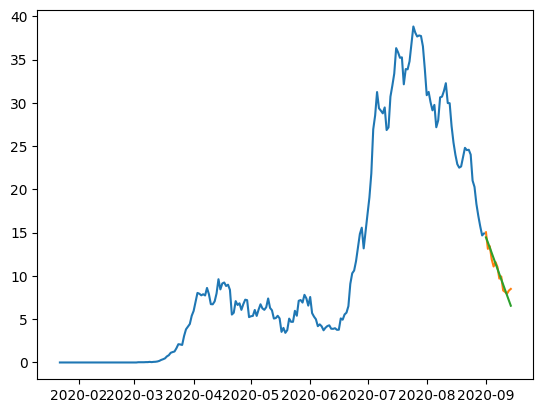

In [74]:
plt.plot(train_data['new_cases_7day_1e6'], label='train')
plt.plot(test_data['new_cases_7day_1e6'], label='test')
plt.plot(fcast)